#Реализация  и обучение классификатора текстов

Обучите модель для определения жанра фильма по его краткому описанию

In [ ]:
%tensorflow_version 2.x

In [ ]:
import nltk
import string
from itertools import chain

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
print(tf.__version__)
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

2.4.1


### Загрузка данных испытания и тесты


In [ ]:
df_train=pd.read_table('/content/train_data.txt',sep=' ::: ',names=['ID','TITLE','GENRE','DESCRIPTION'])

/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


In [ ]:
#df_test=pd.read_table('/content/test_data.txt',sep=' ::: ',names=['ID','TITLE','DESCRIPTION'])

/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


Во время загрузки датасета можно указать, какое подмножество словаря мы хотим использовать, указав `num_words=VOCAB_SIZE`, тогда останутся только самые частые слова.

В датасете последовательности (предложения) уже представлены индексами слов.

In [ ]:
# стоп-слова
stop_words = [
    'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd",
    'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers',
    'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which',
    'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been',
    'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if',
    'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between',
    'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out',
    'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why',
    'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not',
    'only', 'own', 'same', 'so', 'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', "don't", 'shold',
    "should've", 'now', 'd', 'll', 'm', 'o', 're', 've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't",
    'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't",
    'ma', 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't",
    'wasn', "wasn't", 'weren', "weren't", 'won', "won't", 'wouldn', "wouldn't"]

In [ ]:
# дополнительный словарь со знаками пунктуации
nltk.download('punkt', download_dir='.')

[nltk_data] Downloading package punkt to ....
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
def tokenize_text(raw_text: str):
    """Функция для токенизации текста    
    :param raw_text: исходная текстовая строка
    """
    tokenized_str = nltk.word_tokenize(raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in stop_words )]
    return filtered_tokens

Получение собственного словаря

In [ ]:
lite_list=['adult',  'crime',
       'reality-tv', 'sport', 'animation', 'action', 'fantasy',
        'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war']
df_train_lite=df_train[df_train['GENRE'].isin(lite_list)][['GENRE','DESCRIPTION']]


In [ ]:
tokens=df_train['DESCRIPTION'].apply(tokenize_text).sum()

In [ ]:
tokens=df_train_lite['DESCRIPTION'].apply(tokenize_text).sum()

In [ ]:
unique, counts = np.unique(tokens, return_counts=True)

token_count=np.asarray((unique, counts)).T
#print(token_count)

In [ ]:
df_tokens=pd.DataFrame(data=token_count,
          index=np.array(range(len(token_count))),
          columns=['token','count'])
df_tokens['count_int']=df_tokens['count'].astype(int)
#df_tokens.head()
df_tokens.sort_values('count_int',ascending=False)

,token,count,count_int
818,'s,10852,10852
0,'',4686,4686
2526,``,4654,4654
37172,one,3363,3363
35917,new,2408,2408
...,...,...,...
25904,immigrating,1,1
25908,immodest,1,1
25909,immontrables,1,1
25914,immovable,1,1


In [ ]:
tokens_lite=df_tokens[df_tokens['count_int']>35]
tokens_lite.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3164 entries, 0 to 57808
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token      3164 non-null   object
 1   count      3164 non-null   object
 2   count_int  3164 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 98.9+ KB


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
word= tokens_lite.token.values

In [ ]:
tokenizer = Tokenizer(num_words = 1)
tokenizer.fit_on_texts(word)
word_index = tokenizer.word_index
print(word_index)

{'10': 1, 'award': 2, 'winning': 3, 'dr': 4, 'half': 5, 'hour': 6, 'known': 7, 'mr': 8, 'u': 9, 's': 10, 'vs': 11, 'well': 12, "''": 13, "'d": 14, "'ll": 15, "'re": 16, "'s": 17, "'the": 18, "'ve": 19, '1': 20, '000': 21, '100': 22, '11': 23, '12': 24, '13': 25, '14': 26, '15': 27, '16': 28, '17': 29, '18': 30, '2': 31, '20': 32, '200': 33, '2000': 34, '2004': 35, '2005': 36, '2006': 37, '2007': 38, '2008': 39, '2009': 40, '2010': 41, '2011': 42, '2012': 43, '2013': 44, '2014': 45, '2015': 46, '2016': 47, '20th': 48, '22': 49, '24': 50, '25': 51, '26': 52, '3': 53, '30': 54, '3d': 55, '4': 56, '40': 57, '5': 58, '50': 59, '500': 60, '6': 61, '60': 62, '7': 63, '8': 64, '9': 65, '90': 66, 'abandoned': 67, 'abc': 68, 'abducted': 69, 'abilities': 70, 'ability': 71, 'able': 72, 'aboard': 73, 'abuse': 74, 'academy': 75, 'accept': 76, 'accepts': 77, 'access': 78, 'accident': 79, 'accidentally': 80, 'acclaimed': 81, 'accompanied': 82, 'according': 83, 'account': 84, 'accounts': 85, 'accused':

Стандартный словарь

In [ ]:
word_index = tf.keras.datasets.imdb.get_word_index()

1646592/1641221 [==============================] - 0s 0us/step


# Подготовка данных для модели

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()} 
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNKNOWN>"] = 2

# последовательность индексов в текст
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

# текст в последовательность индексов
def encode_review(text):
    words = text.lower().split()
    words = ['<START>'] + words
    idxs = [word_index.get(word, word_index['<UNKNOWN>']) for word in words]
    return idxs

In [ ]:
label_train=df_train['GENRE']
label_train

0              drama
1           thriller
2              adult
3              drama
4              drama
            ...     
54209         comedy
54210         horror
54211    documentary
54212         comedy
54213        history
Name: GENRE, Length: 54214, dtype: object

In [ ]:
token_train=df_train['DESCRIPTION'].apply(encode_review)
#token_test=df_test['DESCRIPTION'].apply(encode_review)

In [ ]:
token_train=df_train_lite['DESCRIPTION'].apply(encode_review)

In [ ]:
from gensim.models import Word2Vec
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

texts=df_train_lite['DESCRIPTION'].apply(tokenize_text)
#texts = df_train_lite['DESCRIPTION'].tolist()[0]


In [ ]:
texts

2        [bus, empties, students, field, trip, museum, ...
7        [ron, petrie, keanu, reeves, troubled, teen, w...
8        [sudden, calamitous, event, causing, great, lo...
18       [modern, roller, derby, began, austin, tx, 200...
19       [story, revolves, around, bird, called, 'hummi...
                               ...                        
54201    [rhiannon, outlaw, regularly, robs, gold, stag...
54203    [100, cupboards, chronicles, fantastical, jour...
54206    [november, 2011, devin, townsend, project, pla...
54208    [first, story, ``, temptation, '', two, kids, ...
54213    [labor, day, weekend, 1935, intense, hurricane...
Name: DESCRIPTION, Length: 11190, dtype: object

In [ ]:
#model = Word2Vec(texts, size=10, window=7, min_count=2, workers=4, iter=10, sg=0)
model = Word2Vec(texts,
size=10,
window=5,
min_count=3,
workers=8)


In [ ]:
voc= list(model.wv.vocab)
voc100=voc[9000:10000]
print(voc[0:100])

['bus', 'empties', 'students', 'field', 'trip', 'museum', 'natural', 'history', 'little', 'tour', 'guide', 'suspect', 'another', 'first', 'lecture', 'films', 'coeds', 'drift', 'dreams', 'erotic', 'fantasies', 'one', 'imagine', 'release', 'emotion', 'uncommon', 'ways', 'slips', 'curator', "'s", 'office', '``', 'finds', 'anthropologist', 'see', 'bones', 'identified', 'even', 'head', 'teacher', "n't", 'immune', 'soon', 'departs', 'everyone', 'admits', 'quite', 'education', 'ron', 'keanu', 'reeves', 'troubled', 'teen', 'whose', 'life', 'hanging', 'thread', 'verge', 'suspension', 'school', 'subject', 'arrest', 'breaking', 'entering', 'cause', 'single', 'mother', 'impending', 'eviction', 'apartment', 'unless', 'find', 'resolution', 'option', 'seems', 'street', 'crime', 'sudden', 'event', 'causing', 'great', 'loss', 'damage', 'hardship', 'like', 'flood', 'tornado', 'airplane', 'crash', 'earthquake', 'documentary', 'live', 'account', 'dramatic', 'events', 'real', 'time', 'unique', 'part', 'ser

In [ ]:
texts

2        [bus, empties, students, field, trip, museum, ...
7        [ron, petrie, keanu, reeves, troubled, teen, w...
8        [sudden, calamitous, event, causing, great, lo...
18       [modern, roller, derby, began, austin, tx, 200...
19       [story, revolves, around, bird, called, 'hummi...
                               ...                        
54201    [rhiannon, outlaw, regularly, robs, gold, stag...
54203    [100, cupboards, chronicles, fantastical, jour...
54206    [november, 2011, devin, townsend, project, pla...
54208    [first, story, ``, temptation, '', two, kids, ...
54213    [labor, day, weekend, 1935, intense, hurricane...
Name: DESCRIPTION, Length: 11190, dtype: object

In [ ]:
model.wv.most_similar('bus')

[('trace', 0.998897910118103),
 ('pizza', 0.9983689188957214),
 ('exact', 0.9981462955474854),
 ('blows', 0.9976801872253418),
 ('convinced', 0.9974757432937622),
 ('fearing', 0.9974141716957092),
 ('rendezvous', 0.9973757863044739),
 ('warned', 0.9972994923591614),
 ('empty', 0.9972875714302063),
 ('drives', 0.9972837567329407)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  after removing the cwd from sys.path.


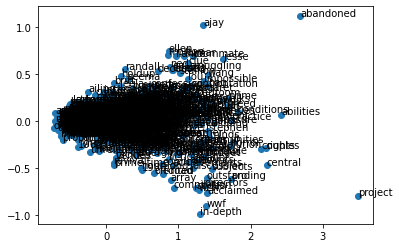

In [ ]:
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot
X = model[voc100]
pca = PCA(n_components=2)
result = pca.fit_transform(X)
# create a scatter plot of the projection
pyplot.scatter(result[:, 0], result[:, 1])
words = voc100#list(model.wv.vocab)
for i, word in enumerate(words):
	pyplot.annotate(word, xy=(result[i, 0], result[i, 1]))
pyplot.show()

In [ ]:
def tokenize_text(raw_text: str):
    """Функция для токенизации текста    
    :param raw_text: исходная текстовая строка
    """
    tokenized_str = nltk.word_tokenize(raw_text)
    tokens = [i.lower() for i in tokenized_str if ( i not in string.punctuation )]
    filtered_tokens = [i for i in tokens if ( i not in stop_words )]
    return filtered_tokens

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# инициализируем объект, который токенизирует наш текст
# в качестве единственного аргимента передаём функцию, которая
# разбивает каждый документ на токены
vectorizer = CountVectorizer(tokenizer=tokenize_text)
# применяем наш объект-токенизатор к датафрейму 
document_matrix = vectorizer.fit_transform(df_train_lite['DESCRIPTION'])
# результат - матрица, в которой находятся числа, строк в мастрице столько, сколько документов
# а столбцов столько, сколько токенов
document_matrix

<11190x58108 sparse matrix of type '<class 'numpy.int64'>'
	with 544511 stored elements in Compressed Sparse Row format>

In [ ]:
document_matrix

<11190x58108 sparse matrix of type '<class 'numpy.int64'>'
	with 544511 stored elements in Compressed Sparse Row format>

In [ ]:
sum(pow((model.wv.get_vector('blows')-model.wv.get_vector('pizza')),2))

0.02735986958577996

In [ ]:
from sklearn.metrics import pairwise_distances

tweet_distance = 1-pairwise_distances(document_matrix, metric="cosine")

tweet_distance.shape

(11190, 11190)

In [ ]:
matrix_05=tweet_distance>0.5
matrix_05.shape

(11190, 11190)

In [ ]:
td_hist=tweet_distance#+0.000001
td_hist_flat=np.triu(td_hist).ravel()[np.flatnonzero(np.triu(td_hist))]
td_hist_flat_log=np.log(td_hist_flat)
fig,ax=plt.subplots(figsize=(10,6))
#ax.hist(td_hist_flat,bins=20,color='blue',alpha=0.5,rwidth=0.95)
ax.hist(td_hist_flat_log,bins=20,color='blue',alpha=0.5,rwidth=0.95)

ax.tick_params(labelsize=12,labelcolor='White')
ax.set_xticks(np.linspace(-6,-1,11))

ax.set_title('Гистограмма распределения схожести твиттов',fontsize=16,color='White')
ax.set_xlabel('схожесть',fontsize=14,color='White')
ax.set_ylabel('число пар твиттов',fontsize=14,color='White')

In [ ]:
!pip install -q tensorflow-text

     |████████████████████████████████| 3.4MB 16.1MB/s 


In [ ]:
import tensorflow_hub as hub
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = make_bert_preprocess_model(['my_input1'], 256)
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(27, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [ ]:
def make_bert_preprocess_model(sentence_features, seq_length=128):
  """Returns Model mapping string features to BERT inputs.

  Args:
    sentence_features: a list with the names of string-valued features.
    seq_length: an integer that defines the sequence length of BERT inputs.

  Returns:
    A Keras Model that can be called on a list or dict of string Tensors
    (with the order or names, resp., given by sentence_features) and
    returns a dict of tensors for input to BERT.
  """

  input_segments = [
      tf.keras.layers.Input(shape=(), dtype=tf.string, name=ft)
      for ft in sentence_features]

  # Tokenize the text to word pieces.
  bert_preprocess = hub.load(tfhub_handle_preprocess)
  tokenizer = hub.KerasLayer(bert_preprocess.tokenize, name='tokenizer')
  segments = [tokenizer(s) for s in input_segments]

  # Optional: Trim segments in a smart way to fit seq_length.
  # Simple cases (like this example) can skip this step and let
  # the next step apply a default truncation to approximately equal lengths.
  truncated_segments = segments

  # Pack inputs. The details (start/end token ids, dict of output tensors)
  # are model-dependent, so this gets loaded from the SavedModel.
  packer = hub.KerasLayer(bert_preprocess.bert_pack_inputs,
                          arguments=dict(seq_length=seq_length),
                          #output_shape=[seq_length],
                          name='packer')
  model_inputs = packer(truncated_segments)
  return tf.keras.Model(input_segments, model_inputs)

In [ ]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

In [ ]:
tf.keras.utils.plot_model(classifier_model)

In [ ]:
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metrics = tf.keras.metrics.SparseCategoricalAccuracy(
        'accuracy', dtype=tf.float32)

In [ ]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [ ]:
label_name=df_train['GENRE'].unique()
label_name

array(['drama', 'thriller', 'adult', 'documentary', 'comedy', 'crime',
       'reality-tv', 'horror', 'sport', 'animation', 'action', 'fantasy',
       'short', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

In [ ]:
label_name=df_train_lite['GENRE'].unique()
label_name

array(['adult', 'crime', 'reality-tv', 'sport', 'animation', 'action',
       'fantasy', 'sci-fi', 'music', 'adventure', 'talk-show', 'western',
       'family', 'mystery', 'history', 'news', 'biography', 'romance',
       'game-show', 'musical', 'war'], dtype=object)

In [ ]:
genre_count=df_train.groupby(['GENRE']).count().reset_index()
genre_count.sort_values('ID',ascending=False)

,GENRE,ID,TITLE,DESCRIPTION
8,drama,13613,13613,13613
7,documentary,13096,13096,13096
5,comedy,7447,7447,7447
21,short,5073,5073,5073
13,horror,2204,2204,2204
24,thriller,1591,1591,1591
0,action,1315,1315,1315
26,western,1032,1032,1032
18,reality-tv,884,884,884
9,family,784,784,784


Кодирование меток

In [ ]:
label_train=df_train_lite['GENRE'].values
label_train

array(['adult', 'crime', 'reality-tv', ..., 'music', 'family', 'history'],
      dtype=object)

In [ ]:
label_num=[]
m=0
for i in range(len(label_train)):
  for m in range(len(label_name)):  
    if label_train[i]==label_name[m]:
      label_num.append(m)

In [ ]:
MAX_SEQ_LEN = 128 # Финальная длина последовательности

train_data = tf.keras.preprocessing.sequence.pad_sequences(
    token_train,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

### Создание модели
Создадим модель для классификации текстов.


In [ ]:
EMB_SIZE = 16 # Размер векторного представления (эмбеддинга)
VOCAB_SIZE=len(word_index)+1

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(len(label_name), activation=tf.nn.softmax),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 64)          5669632   
_________________________________________________________________
global_average_pooling1d (Gl (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080      
_________________________________________________________________
dense_1 (Dense)              (None, 21)                693       
Total params: 5,672,405
Trainable params: 5,672,405
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.GlobalAveragePooling1D(),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(df_train['GENRE'].nunique(), activation=tf.nn.softmax),
])

model.summary()

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(VOCAB_SIZE, EMB_SIZE),
    tf.keras.layers.LSTM(16, return_sequences=False, dropout=0.5, recurrent_dropout=0.5),
    tf.keras.layers.Dense(len(label_name), activation=tf.nn.softmax),
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 16)          50592     
_________________________________________________________________
lstm (LSTM)                  (None, 16)                2112      
_________________________________________________________________
dense (Dense)                (None, 21)                357       
Total params: 53,061
Trainable params: 53,061
Non-trainable params: 0
_________________________________________________________________


In [ ]:
y = model(x)
print(y.shape)

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',            
              metrics=['acc'])

In [ ]:
label_num_np=np.array(label_num)

In [ ]:
partial_x_train, x_val, partial_y_train, y_val = train_test_split(train_data,label_num_np, test_size=0.2, random_state=7, stratify=label_num_np)

In [ ]:
BATCH_SIZE = 256
NUM_EPOCHS =200

history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=NUM_EPOCHS,
                    batch_size=BATCH_SIZE,
                    validation_data=(x_val, y_val),
                    verbose=1)

Epoch 1/200
35/35 [==============================] - 17s 482ms/step - loss: 0.7409 - acc: 0.7496 - val_loss: 3.2486 - val_acc: 0.3986
Epoch 2/200
35/35 [==============================] - 17s 477ms/step - loss: 0.7471 - acc: 0.7407 - val_loss: 3.2349 - val_acc: 0.3954
Epoch 3/200
35/35 [==============================] - 17s 473ms/step - loss: 0.7428 - acc: 0.7525 - val_loss: 3.2817 - val_acc: 0.3990
Epoch 4/200
35/35 [==============================] - 17s 498ms/step - loss: 0.7435 - acc: 0.7522 - val_loss: 3.2770 - val_acc: 0.3986
Epoch 5/200
35/35 [==============================] - 17s 482ms/step - loss: 0.7428 - acc: 0.7502 - val_loss: 3.2773 - val_acc: 0.4013
Epoch 6/200
35/35 [==============================] - 17s 476ms/step - loss: 0.7249 - acc: 0.7506 - val_loss: 3.2730 - val_acc: 0.3945
Epoch 7/200
35/35 [==============================] - 17s 488ms/step - loss: 0.7188 - acc: 0.7584 - val_loss: 3.2740 - val_acc: 0.3968
Epoch 8/200
35/35 [==============================] - 17s 480ms

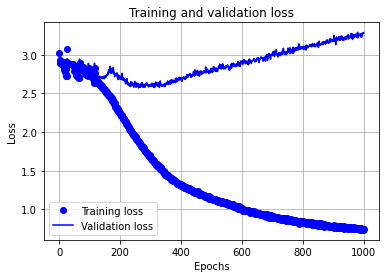

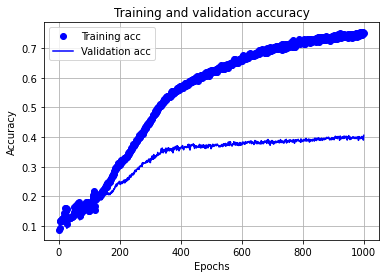

In [ ]:
epochs = range(1, len(history.history['acc']) + 1)

plt.figure()
plt.plot(epochs, history.history['loss'], 'bo', label='Training loss')
plt.plot(epochs, history.history['val_loss'], 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

plt.figure()
plt.plot(epochs, history.history['acc'], 'bo', label='Training acc')
plt.plot(epochs, history.history['val_acc'], 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

In [ ]:
pred_test=[]
for i in token_test:
  prediction = model.predict(np.array(i)[None, :])
  #np.argmax(prediction)
  pred_test.append(label_name[np.argmax(prediction)])
  #print(label_name[np.argmax(prediction)])
#pred_test 

In [ ]:
pred_test_base_dict=np.array(pred_test)
pred_test_base_dict
df_base_dict_pred=pd.DataFrame(data=pred_test_base_dict,
          index=np.array(range(len(pred_test_base_dict))),
          columns=['predict'])


In [ ]:
pred_self_dict=np.array(pred_test)
#pred_test_base_dict
df_self_dict_pred=pd.DataFrame(data=pred_self_dict,
          index=np.array(range(len(pred_test_base_dict))),
          columns=['predict'])


Прогноз с использованием словаря полученного по данным обучающего DataFrame (train_data)

In [ ]:
df_self_dict_pred.head()

,predict
0,thriller
1,drama
2,documentary
3,drama
4,drama


Прогноз по модели с использованием словаря tf

In [ ]:
df_base_dict_pred.head()

,predict
0,thriller
1,drama
2,documentary
3,drama
4,drama


In [ ]:
df_base_dict_pred.to_csv('df_base_dict_pred.csv')
df_self_dict_pred.to_csv('df_self_dict_pred.csv')

In [ ]:
df_tokens.to_csv('tokens_train.csv')

In [ ]:
df_test_sol=pd.read_table('/content/test_data_solution.txt',sep=' ::: ',names=['ID','TITLE','GENRE','DESCRIPTION'])

/usr/local/lib/python3.6/dist-packages/pandas/io/parsers.py:767: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  return read_csv(**locals())


In [ ]:
df_tokens=pd.read_csv('/content/tokens_train.csv')

## Загрузка данных для проверки модели

In [ ]:
token_test=df_test_sol['DESCRIPTION'].apply(encode_review)

In [ ]:
test_data = tf.keras.preprocessing.sequence.pad_sequences(
    token_test,
    value=word_index["<PAD>"],
    padding='post',
    maxlen=MAX_SEQ_LEN)

In [ ]:
test_labels=df_test_sol['GENRE'].values

In [ ]:
label_test_num=[]
m=0
for i in range(len(test_labels)):
  for m in range(len(label_name)):  
    if test_labels[i]==label_name[m]:
      label_test_num.append(m)


In [ ]:
label_test=np.array(label_test_num)

### Оценка качества на тестовом датасете

In [ ]:
results = model.evaluate(test_data, label_test)

print('Test loss: {:.4f}'.format(results[0]))
print('Test accuracy: {:.2f} %'.format(results[1]*100))

1694/1694 [==============================] - 3s 2ms/step - loss: 1.6802 - acc: 0.5385
Test loss: 1.6802
Test accuracy: 53.85 %
